In [2]:
# prompt: download and move to Data folder import kagglehub
# import os
# # Download latest version
# path = kagglehub.dataset_download("kazanova/sentiment140")
# print("Path to dataset files:", path)

import kagglehub
import os
import shutil

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Path to dataset files:", path)

# Create 'Data' folder if it doesn't exist
if not os.path.exists('Data'):
    os.makedirs('Data')

# Move the downloaded files to the 'Data' folder
for filename in os.listdir(path):
    src_path = os.path.join(path, filename)
    dst_path = os.path.join('Data', filename)
    shutil.move(src_path, dst_path)

print("Files moved to Data folder successfully.")

100%|██████████| 80.9M/80.9M [00:02<00:00, 29.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2
Files moved to Data folder successfully.


In [3]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [4]:

# Load Sentiment140 Dataset
df = pd.read_csv('Data/sentiment140.csv', encoding='latin-1', header=None, usecols=[0, 5], names=['sentiment', 'text'])
df['sentiment'] = df['sentiment'].replace(4, 1)  # Convert 4 to 1 (positive sentiment)

In [5]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [6]:
# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [7]:
df['text'] = df['text'].apply(clean_text)

In [8]:
# Tokenize and Pad Sequences
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=max_len)

In [9]:
# Prepare target labels
y = df['sentiment'].values

In [10]:
# prompt: download glove embedding  glove.6B.100d.txt

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-10-21 06:29:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-21 06:29:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-21 06:29:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [11]:
# Load GloVe Embeddings
embedding_dim = 100
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [12]:
# Create the Embedding Matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Build the Model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
#Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Train the Model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=128)

Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 160s 15ms/step - accuracy: 0.7686 - loss: 0.4772 - val_accuracy: 0.8044 - val_loss: 0.4221
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 218s 17ms/step - accuracy: 0.8092 - loss: 0.4137 - val_accuracy: 0.8088 - val_loss: 0.4149
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 190s 16ms/step - accuracy: 0.8178 - loss: 0.3991 - val_accuracy: 0.8158 - val_loss: 0.4043
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 194s 15ms/step - accuracy: 0.8221 - loss: 0.3914 - val_accuracy: 0.8181 - val_loss: 0.3997
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 207s 16ms/step - accuracy: 0.8267 - loss: 0.3841 - val_accuracy: 0.8184 - val_loss: 0.3973


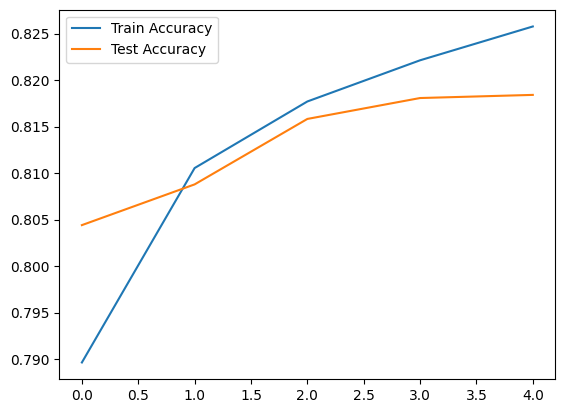

In [17]:
# Plot Accuracy and Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.show()

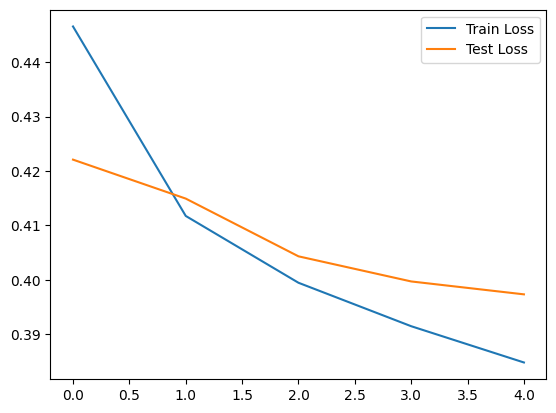

In [18]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

In [19]:
# Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n', cm)
print('Classification Report\n', classification_report(y_test, y_pred))

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step
Confusion Matrix
 [[131990  27504]
 [ 30607 129899]]
Classification Report
               precision    recall  f1-score   support

           0       0.81      0.83      0.82    159494
           1       0.83      0.81      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

